# IGNORE CELLS Until you see another header

In [ ]:
#Define the BaseLocalPlanner object
class BaseLocalPlanner{ #Change to class
    public:
        bool computeVelocityCommands(cmd_vels::Vector{Float64}); #This will be the twist object
        void initialize(name::String, transfromPointer, costmap); # The second variable is a tf::TransfomListener*, costmap_2d::Costmap2DROS*
        bool isGoalReached();
        bool setPlan(path) #input is a constant vector of PoseStamped objects - gives times and positions
        ~BaseLocalPlanner();
    private:
        BaseLocalPlanner();        
}

In [ ]:
#Function polyPathLocal creates a nth order polynomial to be fit and optimized between the current copter configuration
# and a configuration on the global plan.
#Assumptions
# Default global path to plan to is Dijkstras
#Inputs
# Odometry.msg containing
#  current_Position - the current position of the robot, an object with x, y, and z points
#  current_Quaternion - the current orientation of the robot based on quaternions
#  current_Velocity - a vector of current velocities of the robot
#  current_YawRate - a value of yaw rate
# Path.msg either containing or providing
#  desired_Positions - an array of positions x,y,z, yaw = p
#  desired_Velocities - the end velocities for x,y,z,p
#  desired_Acceleration - the end accelerations for x,y,z,p
# flagFMT - a boolean that is true to indicate a computation assuming FMT global plan
# costMap - an array of cost values from 0-255
#Outputs
# Path.msg containing
#  path - an array of positions
#  timeStamps - an array of times corresponding to each position in the path
#  



In [ ]:
#Function computeVelocityCommands will compute the velocity commands to send to the base given current position, orientation
# and velocity
#Inputs
# 
#Outputs
# 
function computeVelocityCommands(cmd_vels::Vector{Float64})
    
    
end

In [ ]:
#Function initialize constructs the local planner
#Inputs
# name - the name to give this instance of the local planner
# tf - a pointer to a transform listener
# costmap_ros - the cost map to use for assignning costs to local plans
#Outputs
# Nothing
function initialize(name::String, tf, costmap)
    #Set name of the object to name
    #Set the tf
#Outputs
# 
function isGoalReached()
    
    #Read in costmap from global centered around robot
end

In [ ]:
#Function isGoalReached checks if the goals has been reached
#Inputs
# 
#Outputs
# 
function isGoalReached()
    
    
end

In [ ]:
#Function setPlan sets the plan that the local planner is following
#Inputs
# 
#Outputs
# 
function setPlan(path)
    
    
end

# This is the first cell to start and they must be run in order if you want good results

In [3]:
include("FunctionsHelper.jl") #my take on poly_helper
#This changed certain functions and got rid of unused ones otherwise it is a copy of poly_helper
#Note some types were changed to make coding easier
seedForRandomness = 0;


21
[3155,3255,3254,3354,3454,3453,3553,3652,3751,3851,3950,4050,4149,4249,4348,4448,4547,4647,4746,4846,4946,5045,5145,5244,5344,5444,5543,5643,5743,5842,5942,6042,6142,6242,6342,6442,6542,6642,6643,6743,6843,6943,6942,7042]


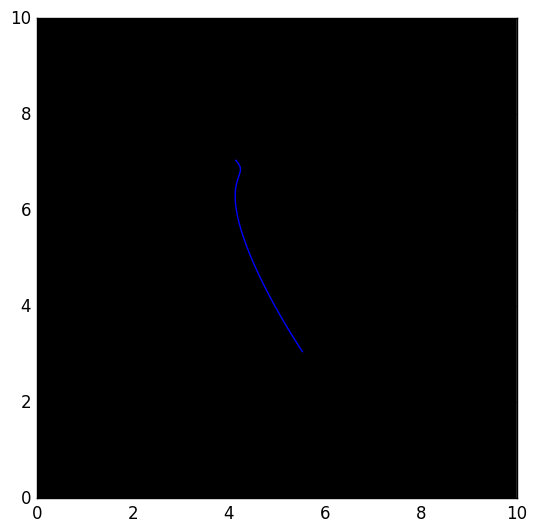

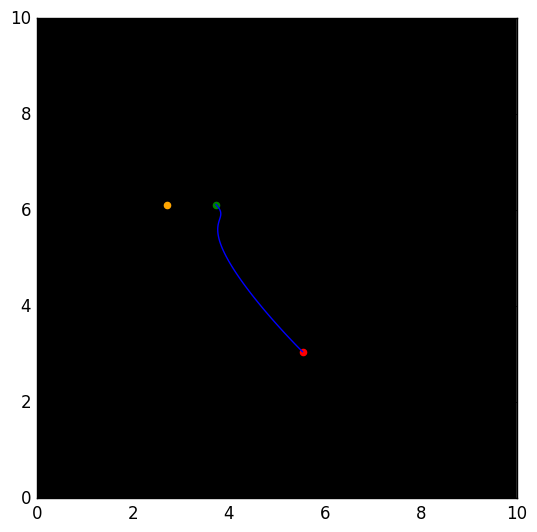

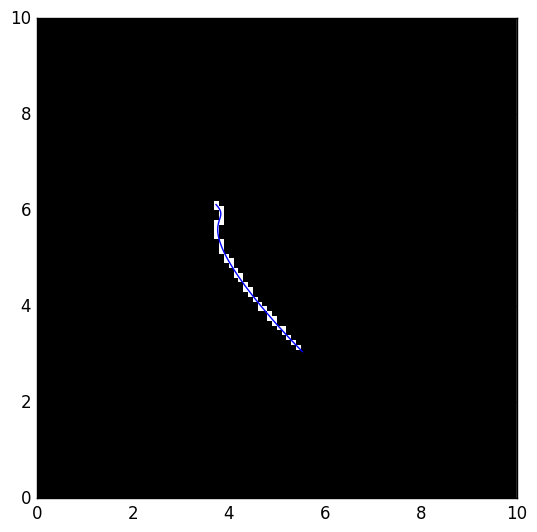

Optimization ended because went through all iterations
[3155,3254,3353,3452,3552,3551,3650,3750,3749,3849,3948,3947,4047,4146,4245,4345,4344,4444,4543,4643,4642,4742,4841,4941,4940,5040,5139,5239,5339,5438,5538,5638,5738,5739,5839,5939,6039,6038,6138]
[3155,3254,3353,3452,3552,3551,3650,3750,3749,3849,3948,3947,4047,4146,4245,4345,4344,4444,4543,4643,4642,4742,4841,4941,4940,5040,5139,5239,5339,5438,5538,5638,5738,5739,5839,5939,6039,6038,6138]
unverified
unverified
unverified
unverified
unverified
unverified
unverified
unverified
unverified
verified
Time of Path: 10.0


PyObject <matplotlib.image.AxesImage object at 0x0000000028026438>

In [45]:

#Function polyPathLocal creates a 7th order polynomial to be fit and optimized between the current copter configuration
# and a configuration on the global plan.
#Assumptions
# Default global path to plan to is Dijkstras
# Average distance for local planner is 10 meters
# Three initial conditions are known
#Inputs
# current_Pos - the initial positions x,y,z, yaw = p
# current_Vel - the initial velocities in x,y,z, yaw = p
# current_Accel - the initial accelerations in x,y,z, yaw = p
# final_Pos - the final positions in x,y,z, yaw = p
# final_Vel - te final velocities in x,y,z, yaw = p
# final_Accel - the final accelerations in x,y,z, yaw = p
# costmap - an array of values from 0-255 to designate cost of traveling in a certain square by obstacles
# q_coeffs - a vector of weights to be applied to the derivative costs
# obstacleWeight - the weight applied to the obstacles in the cost function
# flag - a boolean that will decide between dijkstras or FMT global planning assumption, true -> fmt
# perturbStep - the amount of distance to start the gradient descent
# iterations - number of iterations to optimize over
#Outputs
# polyPath - the coefficients of the polynomial of the planned path
#####################Testing Variables###########################################
#Create costmap
# Form a grid which shows the cells we check:
width = get_grid_extent();
res   = get_grid_resolution();
n = round(Int64,ceil(width/res));
seedForRandomness = 21
srand(seedForRandomness)
println(seedForRandomness)
#interesting seed:14, 15, 21
costmap = zeros(n,n,n)+50;
#Create a certain amount of objects
for tc = 1:20
    index1 = round(rand()*get_grid_extent()/get_grid_resolution());
    index2 = round(rand()*get_grid_extent()/get_grid_resolution());
    for l = 1:size(costmap,1)
        for p = 1:size(costmap,2)
            costmap[l,p,1] += 255/(sqrt((l-index1)^2+(p-index2)^2));
            if(costmap[l,p,1]>255)
                costmap[l,p,1] = 255;
            end
        end
    end
end
#Flip costmap for ploting purposes
costmap = zeros(n,n,n)
pcostmap = costmap[:,:,1];
temp_costmap = zeros(size(pcostmap,1),size(pcostmap,2))
for h =1:size(costmap,1)
    for g = 1:size(costmap,2)
        temp_costmap[h,g,1] = costmap[h,size(pcostmap,2)-g+1,1];
    end
end
temp_costmap=temp_costmap';

#Things for testing random start and end configurations: only change the first number
vel_lim = 0.0*2;
accel_lim = 0.65/4*2;
##########################
current_Pos = Point(rand()*(get_grid_extent()-5)+2,rand()*(get_grid_extent()-5)+2,0,0);
current_Vel = Point((rand()-0.5)*vel_lim,(rand()-0.5)*vel_lim,0,0);
current_Accel = Point(0,0,0,0);
final_Pos = Point(rand()*(get_grid_extent()-5)+2,rand()*(get_grid_extent()-5)+2,0,0);
final_Vel = Point((rand()-0.5)*vel_lim,(rand()-0.5)*vel_lim,0,0);
final_Accel = Point((rand()-0.5)*accel_lim,(rand()-0.5)*accel_lim,0,0);
q_coeff = zeros(6);
#q_coeff[2] = 1;
q_coeff[1]=0;
q_coeff[2]=2;
q_coeff[3] = 0;

obstacleWeight = 10;
lowerQeffs = 100000;
iterations = 100;
perturbStep = 0.01;
perturbStep2 = 0.01;
precision = 0.000001;
dim = 2;
max_vel = 2.0;
max_accel = 0.65;
max_jerk = 100.0;
max_rpm = 100000000000.0;
timeStep  = 0.005;
aggressParam = 0.7;
timeIncrease = 1;
timeStart = 1.0;#sqrt((current_Pos.x-final_Pos.x)^2 + (current_Pos.y - final_Pos.y)^2)/max_vel;
#############################################################################################
#Changeable value
num_free = 2;
num_points = 2;

#Read in the states avaiable in the order initials, finals

    #if dijkstras create a velocity approximation from the two points assuming traversed in a second - this gets relaxed
    #later in the verification step also note the lack of a final acceleration
    x_constr = [current_Pos.x; current_Vel.x; current_Accel.x; (final_Pos.x - current_Pos.x)];
    y_constr = [current_Pos.y; current_Vel.y; current_Accel.y;  (final_Pos.y - current_Pos.y)];
    z_constr = [current_Pos.z; current_Vel.z; current_Accel.z;  (final_Pos.z - current_Pos.z)];

#Set up the constraint matrix in the order initials, finals (plus another constraint for optimization)
num_constr = length(x_constr)+num_free;
#The two corresponds to acceleration being the 2nd derivative three 
#if dijkstras create a free variable of acceleration else create another constraint for jerk
orders = [collect(0:2); collect(1:(2+flag));0];
#Create time vector assuming 1 second for the final conditions and zero for the initial conditions
#There are three zeros for three initial conditions
#The last value is flag to be a one when fmt is used otherwise it will be in the vector as a zero that is never used
times = [0.0;timeStart];
timeIndex = [0;0;0;1;1;1;flag];
#Calculate some numbers
tot_degree = num_constr;


#Set up A matrix so that Ap = d where p is the coefficients of the polynomial and d are the constraints in a vector
A = zeros(tot_degree, tot_degree);
for k=1:tot_degree
    A[k,:] = constr_order(orders[k], times[timeIndex[k]+1],tot_degree);
end
#Calculate A inverse
A_inv = inv(A);
Au = A_inv;
# Form Q matrix where cost = p'Qp without the costmap
Q = form_Q(q_coeff, times[end]-times[1]); 
#Solve for the optimal ends with no costmap first
R = A_inv'*(Q*A_inv);
#short for optimizing matrix
opt_mat = -( R[(tot_degree-num_free+1):tot_degree, (tot_degree-num_free+1):tot_degree])\R[1:(tot_degree-num_free), 
    (tot_degree-num_free+1):tot_degree]';
#Record the optimized value in a variable for later gradient descent; will only work for 1 free variable at the moment
x_free = opt_mat * (x_constr) + [0;final_Pos.x];
y_free = opt_mat * (y_constr) + [0;final_Pos.y];
z_free = opt_mat * (z_constr) + [0;final_Pos.z];

x_coeffs = A_inv * [x_constr; x_free];
y_coeffs = A_inv * [y_constr; y_free];
z_coeffs = A_inv * [z_constr; z_free];


#Plot the poly optimized only for derivative costs
figure()
plotTimes = linspace(0,times[end],100);
plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
#Check the cost with the costmap by first finding the squares the path goes through
#Find the cells of that the polynomial passes through; the last 5 inputs here are the three grid resolutions,
# the dimension and an aggression param
pcells,outOfBounds = occupancyCellChecker(x_coeffs, y_coeffs, z_coeffs, timeIndex, get_grid_resolution(), 
    get_grid_resolution(), get_grid_resolution(), dim, aggressParam,timeStep);
println(pcells)
#Check if out of bounds and avoid loop
if(outOfBounds)
    println("path went out of bounds")
    unOptimized = false;
else
    #The division by three is to normalize the costs from the coefficients#
    cost1 = (x_coeffs' * Q * x_coeffs + y_coeffs' * Q * y_coeffs + z_coeffs' * Q * z_coeffs)/3/lowerQeffs +
    obstacleWeight*sum(costmap[cells]);
    x_coeffs, y_coeffs, z_coeffs, pcells, outOfBounds = crudyGradientDescent(iterations, perturbStep, x_coeffs, y_coeffs, 
        z_coeffs, times, dim, aggressParam, timeStep, Q, A_inv, x_constr, x_free,y_free, z_free, cost1, 
        costmap, perturbStep2)
    #Set tcells to cells CELLS are broken and I do not know why

end
println(pcells)
#Start repeat if not verified
unverified = true;
counter2 = 0;
timeV = times[end];
sol = PolySol(num_points-1, times, x_coeffs, y_coeffs, z_coeffs, zeros(size(z_coeffs,1))); 
while(unverified && !outOfBounds)
    #verfiy path is feasible based on constraints    
    errorTimes = verifyActuateablePath(sol, max_vel*timeV, max_accel*timeV^2, max_jerk*timeV^3, max_rpm, dim, 6+flag);
    #println(errorTimes)
    #Redo the calculation with a larger time if there are errors
    if(!isempty(errorTimes) && counter2 < 100)
        #Start a while loop to loop until the path is optimized
        println("unverified")
        unverified = true;
        counter2 += timeIncrease;
        timeV += timeIncrease;
    else
        if(counter2 >= 100)
            println("not verified in less than 100s")
        else
            println("verified")
            println("Time of Path: ", timeV)
        end
        unverified = false;
    
    end
end

#Check if not out of bounds 
if(!outOfBounds)    
    figure()
    plotTimes = linspace(0,times[end],100);
    plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
    scatter(current_Pos.x,current_Pos.y,color = "red")
    scatter(final_Pos.x,final_Pos.y, color = "orange")
    scatter(evaluate_poly(x_coeffs,0,1), evaluate_poly(y_coeffs,0,1),color= "green")
    imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
     
    #Plot occupancy grid
    for d in pcells
        costmap[d]=255;
         #Flip costmap for ploting purposes
        pcostmap = costmap[:,:,1];
        temp_costmap = zeros(size(pcostmap,1),size(pcostmap,2))
        for h =1:size(costmap,1)
            for g = 1:size(costmap,2)
                temp_costmap[h,g,1] = costmap[h,size(pcostmap,2)-g+1,1];
            end
        end
        temp_costmap=temp_costmap';
    end
        figure()
    plotTimes = linspace(0,times[end],100);
    plot(evaluate_poly(x_coeffs,0,plotTimes), evaluate_poly(y_coeffs,0,plotTimes));
    imshow(temp_costmap,cmap="gray", interpolation="none",extent=[0,width,0,width])
end

#Return path



crudyGradientDescent (generic function with 1 method)

Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any, Any) in module Main at In[40]:5 overwritten at In[42]:5.


In [ ]:
workspace();